In [1]:
import astropy
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
from astropy.stats import Events, bayesian_blocks

In astropy the function `bayesian_blocks` is implemented such that one can either pass a string for the type of data, a fitness function that is an instance of the class `FitnessFunc` or a subclass of `FitnessFunc`.
To implement bayesian blocks with exponential functions we just create a subclass of `FitnessFunc` that implements exponential bounds. This way using the algorithm will be as easy as
```python
edges = bayesian_blocks(t, x, fitness=ExponentialBlocks_Events, p0=0.01)
```

In [2]:
class ExponentialBlocks_Events(Events):
    
    def anti_N_k(self,N_k):
        x = np.zeros(len(N_k))
        x[-1]=N_k[-1]
        for i in range(len(N_k)-1):
            x[i] = N_k[i]-N_k[i+1]
        return x
    
    def compute_a(self,T_k,N_k,S_k):
        """Computes as instructed by eq. C116 in Scargle (2013).

        Parameters
        ---------
        N_k : array-like
            number of events in blocks in receding order (from last to first)
        T_k : array-like, float
            length of the blocks in decreasing order
        ---------

        Returns
        ---------
        a : array-like
            optimal parameter for each block identified by T_k
        """
        a = np.ones_like(T_k,dtype=float)
        f = 1
        i = 1
        #print(f'T_k:{T_k},N_k:{N_k},S_k:{S_k}')
        #implementation of Newton's method to find optimal a
        while i<100 and np.any(np.abs(f)>1e-8):
            #Q_k defined as in C114 of Scargle (2013)
            Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))
            #f defined as in C109 of Scargle (2013)
            f = (1/a) - T_k*Q_k + S_k
            #f_prime defined as in C113 of Scargle (2013)
            f_prime = -(1/(a*a)) + T_k*T_k*Q_k*(1+Q_k)
            a -= np.divide(f,f_prime)
            
            #print(a)
            #a = np.clip(a,bound_l,bound_r)
            
            #print(i,max(np.abs(f)),a)
            #print(f'a:{a}')
            i += 1
        #print(i,max(np.abs(f)))
        return a
    
    def fitness(self,T_k,N_k):
        #S_k defined as in C110 of Scargle (2013)
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        a = self.compute_a(T_k,N_k,S_k)
        # C105 from Scargle (2013) (Scargle calls this just block likelihood but it is actually the block log-likelihood)
        log_likelihood = N_k * np.log((a*N_k)/(1-np.exp(-a*T_k))) + a*N_k*S_k - N_k
        return log_likelihood
    
    def get_parameters(self,edge_l,edge_r,t,x):
        T_k,N_k,S_k = self.get_T_k_N_k_S_k_from_edges(edge_l,edge_r,t,x)
        a = self.compute_a(T_k,N_k,S_k)
        gamma = np.divide(a*N_k,1-np.exp(-a*T_k))
        return {'a':a[0],'gamma':gamma[0]}

    def get_T_k_N_k_S_k_from_edges(self,edge_l,edge_r,t,x):
        flagStart=0
        flagEnd=0
        t_end_index=0
        for i,t_d in enumerate(t):
            if edge_l<=t_d and t_d<=edge_r:
                if flagStart==0:
                    flagStart=1
                    t_start_index=i
            elif t_d>edge_r and flagEnd==0:
                flagEnd=1
                t_end_index=i
        if t_end_index == 0:
            t_end_index = len(t)
        t_new = t[t_start_index:t_end_index]
        x_new = x[t_start_index:t_end_index]
        #print(t_new)
        #print(x_new)
        edges = np.concatenate([np.array([edge_l]), 0.5 * (t_new[1:] + t_new[:-1]), np.array([edge_r])])
        #print(edges)
        #print(len(edges))
        block_length = t_new[-1] - edges
        #print(block_length)
        T_k = block_length[:-1] - block_length[-1]
        N_k = np.cumsum(x_new[::-1])[::-1]
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        return T_k,N_k,S_k

In [3]:
class ExponentialBlocks_Events_Alt(Events):
    r""" Bayesian Blocks Fitness for binned or unbinned events with piecewise exponential function over the blocks
    
    Parameters
    ----------
    p0 : float, optional
        False alarm probability, used to compute the prior on
        :math:`N_{\rm blocks}` (see eq. 21 of Scargle 2013). For the Events
        type data, ``p0`` does not seem to be an accurate representation of the
        actual false alarm probability. If you are using this fitness function
        for a triggering type condition, it is recommended that you run
        statistical trials on signal-free noise to determine an appropriate
        value of ``gamma`` or ``ncp_prior`` to use for a desired false alarm
        rate.
    gamma : float, optional
        If specified, then use this gamma to compute the general prior form,
        :math:`p \sim {\tt gamma}^{N_{\rm blocks}}`.  If gamma is specified, p0
        is ignored.
    ncp_prior : float, optional
        If specified, use the value of ``ncp_prior`` to compute the prior as
        above, using the definition :math:`{\tt ncp\_prior} = -\ln({\tt
        gamma})`.
        If ``ncp_prior`` is specified, ``gamma`` and ``p0`` is ignored.
    """

    def anti_N_k(self,N_k):
        x = np.zeros(len(N_k))
        x[-1]=N_k[-1]
        for i in range(len(N_k)-1):
            x[i] = N_k[i]-N_k[i+1]
        return x
    
    def fitness(self, N_k, T_k):
        # C105 from Scargle (2013) (even if it was called likelihood that is an error, it is the log-likelihood)
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        arr=np.array([])
        for n,t,s in zip(N_k,T_k,S_k):
            def neg_likelihood(a):
                #if np.abs(a*t)<1e-8: #numerical trick to elude the evaluation of 1/(1-np.exp(-a*t)) when the denominator would be close to 0
                #    return -n*(a*s+np.log(n/t)-1)
                if a*t<-20:  #numerical trick to elude the evaluation of np.exp(-a*t), the two functions differ by less than 1e-9
                    return -n*(np.log(-n*a)+a*t+a*s-1)
                return -n*(np.log((a*n)/(1-np.exp(-a*t)))+a*s-1)
            opt_val = -scipy.optimize.minimize_scalar(neg_likelihood,bracket=(-10,10)).fun
            #if opt_val<=0:
                #print(f'Negative optimal likelihood for values (t,n,s):{t,n,s}')
                #print(f'opt_val: {opt_val}')
                #opt_val = 0.0001
            arr=np.append(arr,opt_val)
        #likelihood = n*(np.log((a*n)/(1-np.exp(-a*t)))+a*s-1)
        #print(max(arr))
        return arr
    
    def get_parameters(self,edge_l,edge_r,t,x):
        T_k,N_k,S_k = self.get_T_k_N_k_S_k_from_edges(edge_l,edge_r,t,x)
        t,n,s = T_k[0],N_k[0],S_k[0]
        def neg_likelihood(a):
            return -n*(np.log((a*n)/(1-np.exp(-a*t)))+a*s-1)
        a = scipy.optimize.minimize_scalar(neg_likelihood).x
        #likelihood = n*(np.log((a*n)/(1-np.exp(-a*t)))+a*s-1)
        gamma = np.divide(a*n,1-np.exp(-a*t))
        return {'a':a,'gamma':gamma}

    def get_T_k_N_k_S_k_from_edges(self,edge_l,edge_r,t,x):
        flagStart=0
        flagEnd=0
        t_end_index=0
        for i,t_d in enumerate(t):
            if edge_l<=t_d and t_d<=edge_r:
                if flagStart==0:
                    flagStart=1
                    t_start_index=i
            elif t_d>edge_r and flagEnd==0:
                flagEnd=1
                t_end_index=i
        if t_end_index == 0:
            t_end_index = len(t)
        t_new = t[t_start_index:t_end_index]
        x_new = x[t_start_index:t_end_index]
        #print(t_new)
        #print(x_new)
        edges = np.concatenate([np.array([edge_l]), 0.5 * (t_new[1:] + t_new[:-1]), np.array([edge_r])])
        #print(edges)
        #print(len(edges))
        block_length = t_new[-1] - edges
        #print(block_length)
        T_k = block_length[:-1] - block_length[-1]
        N_k = np.cumsum(x_new[::-1])[::-1]
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        #print(T_k,N_k,S_k)
        return T_k,N_k,S_k

In [4]:
class ExponentialBlocks_Events_Alt_2(Events):
    r""" Bayesian Blocks Fitness for binned or unbinned events with piecewise exponential function over the blocks
    
    Parameters
    ----------
    p0 : float, optional
        False alarm probability, used to compute the prior on
        :math:`N_{\rm blocks}` (see eq. 21 of Scargle 2013). For the Events
        type data, ``p0`` does not seem to be an accurate representation of the
        actual false alarm probability. If you are using this fitness function
        for a triggering type condition, it is recommended that you run
        statistical trials on signal-free noise to determine an appropriate
        value of ``gamma`` or ``ncp_prior`` to use for a desired false alarm
        rate.
    gamma : float, optional
        If specified, then use this gamma to compute the general prior form,
        :math:`p \sim {\tt gamma}^{N_{\rm blocks}}`.  If gamma is specified, p0
        is ignored.
    ncp_prior : float, optional
        If specified, use the value of ``ncp_prior`` to compute the prior as
        above, using the definition :math:`{\tt ncp\_prior} = -\ln({\tt
        gamma})`.
        If ``ncp_prior`` is specified, ``gamma`` and ``p0`` is ignored.
    """

    def anti_N_k(self,N_k):
        x = np.zeros(len(N_k))
        x[-1]=N_k[-1]
        for i in range(len(N_k)-1):
            x[i] = N_k[i]-N_k[i+1]
        return x
    
    def compute_a(self,T_k,N_k,S_k):
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        def Q(a):
            tmp = np.clip(a*T_k,-20,20)
            return np.exp(-tmp)/(1-np.exp(-tmp))
        def f(a):
            return (1/a)-T_k*Q(a)+S_k
        def f_prime(a):
            Q_k=Q(a)
            return -(1/(a**2))+(T_k**2)*Q_k*(1+Q_k)
        def f_second(a):
            Q_k = Q(a)
            return 2/(a**3)-(T_k**3)*Q_k*(1+Q_k)*(1+2*Q_k)
        try:
            a = scipy.optimize.newton(f,np.ones_like(T_k),fprime=f_prime,fprime2=f_second)
        except Exception as e:
            print('Occhio')
            a=1
        return a
        
    def fitness(self, N_k, T_k):
        # C105 from Scargle (2013) (even if it was called likelihood that is an error, it is the log-likelihood)
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        a = self.compute_a(T_k,N_k,S_k)
        return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
    
    def compute_ncp_prior(self, N):
        """
        If ``ncp_prior`` is not explicitly defined, compute it from ``gamma``
        or ``p0``.
        """
        if self.gamma is not None:
            return -np.log(self.gamma)
        elif self.p0 is not None:
            return self.p0_prior(N)
        else:
            raise ValueError(
                "``ncp_prior`` cannot be computed as neither "
                "``gamma`` nor ``p0`` is defined."
            )
            
    def p0_prior(self, N):
        """Empirical prior, parametrized by the false alarm probability ``p0``.
        """
        return -1791 + 0.01581 * N - 816.85 * self.p0 + 0.0025385 * self.p0 * N
    
    def get_parameters(self,edge_l,edge_r,t,x):
        T_k,N_k,S_k = self.get_T_k_N_k_S_k_from_edges(edge_l,edge_r,t,x)
        a = self.compute_a(T_k,N_k,S_k)
        gamma = np.divide(a*N_k,1-np.exp(-a*T_k))
        try:
            a[0]
            a_array=True
        except Exception as e:
            a_array=False
        if a_array:
            return {'a':a[0],'gamma':gamma[0]}
        return {'a':a,'gamma':gamma}

    def get_T_k_N_k_S_k_from_edges(self,edge_l,edge_r,t,x):
        flagStart=0
        flagEnd=0
        t_end_index=0
        for i,t_d in enumerate(t):
            if edge_l<=t_d and t_d<=edge_r:
                if flagStart==0:
                    flagStart=1
                    t_start_index=i
            elif t_d>edge_r and flagEnd==0:
                flagEnd=1
                t_end_index=i
        if t_end_index == 0:
            t_end_index = len(t)
        t_new = t[t_start_index:t_end_index]
        x_new = x[t_start_index:t_end_index]
        #print(t_new)
        #print(x_new)
        edges = np.concatenate([np.array([edge_l]), 0.5 * (t_new[1:] + t_new[:-1]), np.array([edge_r])])
        #print(edges)
        #print(len(edges))
        block_length = t_new[-1] - edges
        #print(block_length)
        T_k = block_length[:-1] - block_length[-1]
        N_k = np.cumsum(x_new[::-1])[::-1]
        S_k = -(1/N_k)*(np.cumsum((T_k*self.anti_N_k(N_k))[::-1])[::-1])
        #print(T_k,N_k,S_k)
        return T_k,N_k,S_k

In [5]:
def test_bb_exp(t,x,fitn = ExponentialBlocks_Events, **kwargs):
    plt.step(t, x)
    xcoords = bayesian_blocks(t,x,fitness=fitn, **kwargs)
    for xc in xcoords:
        plt.axvline(x=xc, color='grey', alpha=0.3)
    print(f'Estremi: {xcoords}')
    for i in range(len(xcoords)-1):
        edge_l = xcoords[i]
        edge_r = xcoords[i+1]
        params = fitn(**kwargs).get_parameters(edge_l,edge_r,t,x)
        a = params['a']
        gamma = params['gamma']
        print(f'Blocco {i}: a={a},gamma={gamma}')
        plot_t = np.linspace(edge_l,edge_r,1000)
        plot_x = gamma * np.exp(a*(plot_t - edge_r))
        plt.plot(plot_t,plot_x)
    plt.show()

Occhio


/nix/store/accsh5lqcr70pk635jj2l3qvvbaibl17-python3-3.10.13-env/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:467: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [ 0. 99.]
Blocco 0: a=0.020953734098187897,gamma=121.02001892116314


/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


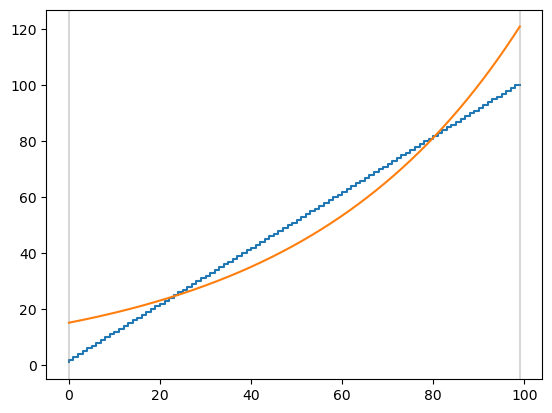

In [6]:
t=np.arange(0,100)
#x=np.floor(np.power(0.9,t)*6000)
x = np.arange(0,100)+1
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior=1000000)

Occhio
Estremi: [1. 3.]
Blocco 0: a=-2.2852503477141797,gamma=0.14343706535727466


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


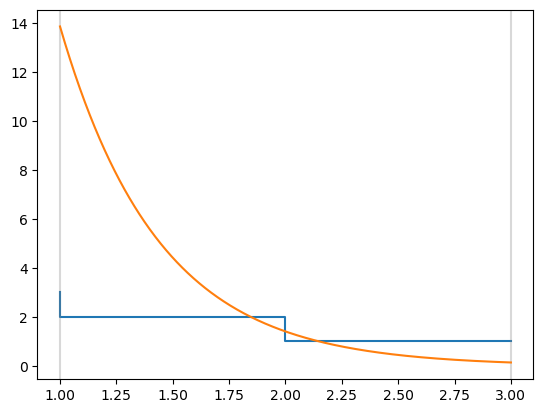

In [7]:
t=np.array([1,2,3])
x=np.array([3,2,1])
edges = np.concatenate([t[:1], 0.5 * (t[1:] + t[:-1]), t[-1:]])
block_length = t[-1] - edges
T_k = block_length[:-1] - block_length[-1]
N_k = np.cumsum(x[::-1])[::-1]
S_k = -(1/N_k)*(np.cumsum((T_k*ExponentialBlocks_Events_Alt().anti_N_k(N_k))[::-1])[::-1])
#print(T_k,N_k,S_k)
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior=10)

Occhio


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [ 0. 99.]
Blocco 0: a=-0.007449464930178069,gamma=102.79165460660863


/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


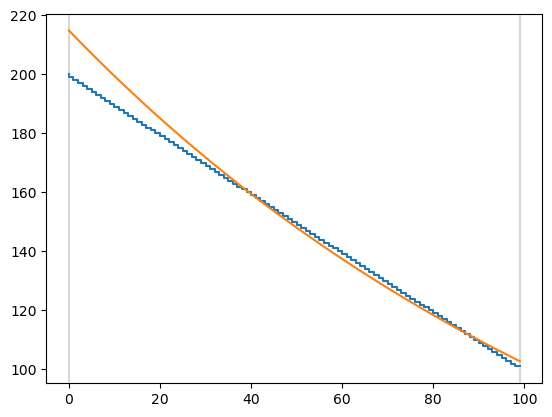

In [8]:
t=np.arange(0,100)
#x=np.floor(np.power(0.9,t)*6000)
x = 200-np.arange(0,100)
edges = np.concatenate([t[:1], 0.5 * (t[1:] + t[:-1]), t[-1:]])
block_length = t[-1] - edges
T_k = block_length[:-1] - block_length[-1]
N_k = np.cumsum(x[::-1])[::-1]
S_k = -(1/N_k)*(np.cumsum((T_k*ExponentialBlocks_Events_Alt().anti_N_k(N_k))[::-1])[::-1])
#print(T_k,N_k,S_k)
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior=1000000)

Occhio


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [ 0. 29.]
Blocco 0: a=0.6666666275477413,gamma=715827842.8701246


/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


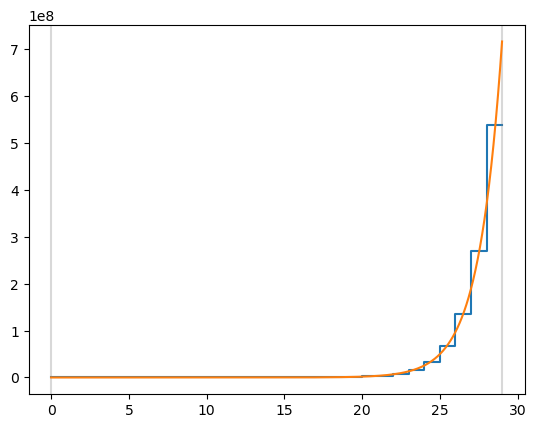

In [9]:
t=np.arange(0,30)
x=np.floor(np.power(2,t))
t=np.arange(0,30)
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior=100000000000)

Occhio


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [ 0. 19.]
Blocco 0: a=-0.5091075887151304,gamma=0.6402218658713494


/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


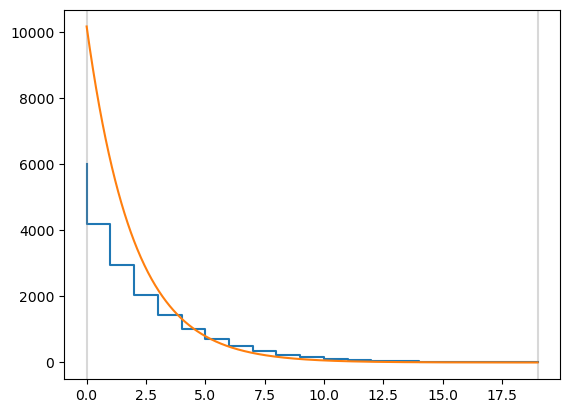

In [24]:
t=np.arange(0,20)
x=np.floor(np.power(0.7,t)*6000)
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior=5000000000000)

Occhio
Estremi: [ 0. 14.]
Blocco 0: a=0.9231032654682065,gamma=1756547.950818277


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


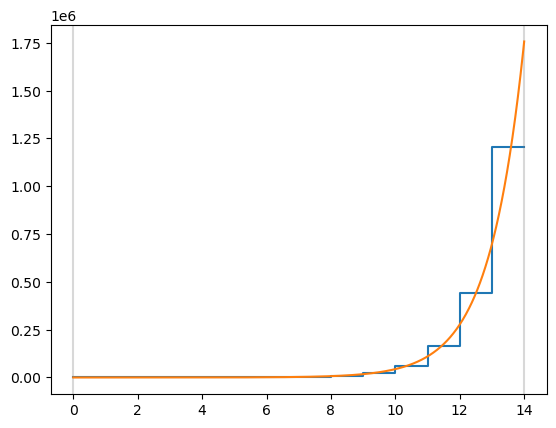

In [11]:
t=np.arange(0,15)
x=np.abs(np.floor(np.exp(t))+np.random.binomial(10000,0.5,15)-5000)+1
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior = 70000000)

Occhio


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [ 0.   1.5 99. ]
Blocco 0: a=-3.9379990295450553,gamma=17.26225975844029
Blocco 1: a=-0.00031729499529146716,gamma=794.8289942357816


/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


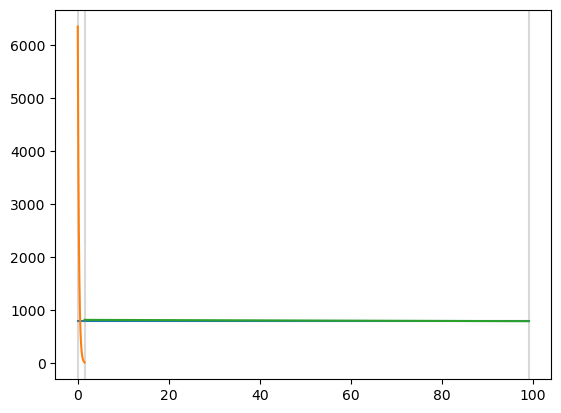

In [22]:
t=np.arange(0,100)
x=800+np.random.binomial(10,0.3,100)
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior=1000)

Occhio


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [ 0.  48.5 99. ]
Blocco 0: a=0.20928720907860454,gamma=157.59942415884487
Blocco 1: a=-0.10614764528597391,gamma=2.150795081870852


/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


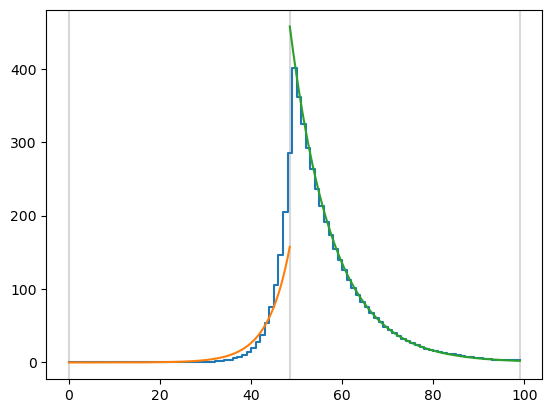

In [21]:
t=np.arange(0,100)
i_stacco = len(t)//2
t_stacco = t[i_stacco]
alpha_1=np.log(1.4)
alpha_2=np.log(0.9)
gamma=400
#+np.random.binomial(10,0.5,100)-5)+1
x_1 = np.floor(gamma*np.exp(alpha_1*(t[:i_stacco]-t_stacco)))+1
x_2 = np.floor(gamma*np.exp(alpha_2*(t[i_stacco:]-t_stacco)))+1
x = np.concatenate((x_1,x_2))
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior=1000)

Occhio


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [ 0.  47.5 99. ]
Blocco 0: a=0.19253212230585975,gamma=105.51886429146982
Blocco 1: a=-0.003947585567036973,gamma=249.80501861781238


/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


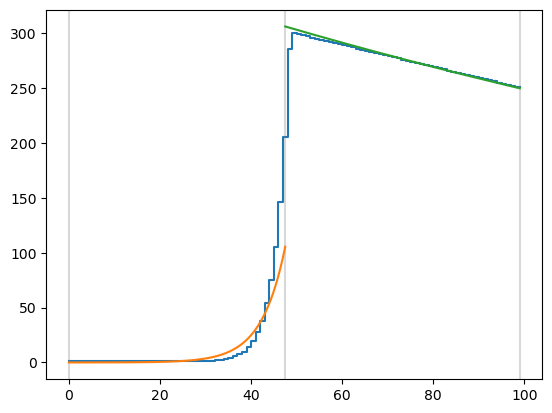

In [20]:
t=np.arange(0,100)
i_stacco = len(t)//2
t_stacco = t[i_stacco]
alpha_1=np.log(1.4)
alpha_2=np.log(0.9)
gamma=400
#+np.random.binomial(10,0.5,100)-5)+1
x_1 = np.floor(gamma*np.exp(alpha_1*(t[:i_stacco]-t_stacco)))+1
x_2 = (gamma-t[i_stacco:]-t_stacco)
x = np.concatenate((x_1,x_2))
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior = 1000)

Occhio


/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/tmp/ipykernel_7176/4110669862.py:57: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)


Estremi: [  0.   70.5  72.5  74.5  76.5  78.5  80.5  82.5  84.5  86.5  88.5  90.5
  92.5  94.5  96.5  98.5 159.5 169.5 171.5 173.5 175.5 177.5 179.5 181.5
 183.5 185.5 187.5 189.5 191.5 193.5 195.5 197.5 199. ]
Blocco 0: a=0.1812691787107794,gamma=1202600.220306513
Blocco 1: a=-1.5544809017664105,gamma=237042.11532216435
Blocco 2: a=-1.5544801297232071,gamma=353625.71460148547
Blocco 3: a=-1.5544806677259866,gamma=527547.1763165138
Blocco 4: a=-1.554480363679405,gamma=787008.3217449032
Blocco 5: a=-1.5544804766748415,gamma=1174078.245707465
Blocco 6: a=-1.5544804777135686,gamma=1751519.0060305034
Blocco 7: a=-1.5544805945232398,gamma=2612958.9307547077
Blocco 8: a=-1.5544805595201034,gamma=3898076.8192601777
Blocco 9: a=-1.554480570684339,gamma=5815247.313860031
Blocco 10: a=-1.554480541386913,gamma=8675329.92071604
Blocco 11: a=-1.554480560955168,gamma=12942071.116213527
Blocco 12: a=-1.5544805630627248,gamma=19307301.316598237
Blocco 13: a=-1.554480557085162,gamma=28803109.17429877
B

/tmp/ipykernel_7176/4110669862.py:62: RuntimeWarning: overflow encountered in exp
  gamma = np.divide(a*N_k,1-np.exp(-a*T_k))


Blocco 17: a=-1.5544804380789612,gamma=194073.82290079177
Blocco 18: a=-1.5544805244367101,gamma=289524.017524327
Blocco 19: a=-1.5544806655475745,gamma=431919.13907683245
Blocco 20: a=-1.5544805208554546,gamma=644347.6979460574
Blocco 21: a=-1.5544807066156705,gamma=961253.6631285544
Blocco 22: a=-1.5544805871976162,gamma=1434022.2058597594
Blocco 23: a=-1.554480550578054,gamma=2139309.9978842344
Blocco 24: a=-1.5544805572908325,gamma=3191475.376853336
Blocco 25: a=-1.5544805272060416,gamma=4761122.076877017
Blocco 26: a=-1.55448056654531,gamma=7102759.096475359
Blocco 27: a=-1.554480563030101,gamma=10596071.620182285
Blocco 28: a=-1.5544805545399347,gamma=15807481.535987962
Blocco 29: a=-1.5544805605262364,gamma=23581991.12599407
Blocco 30: a=-1.554480558987471,gamma=35180196.939835116
Blocco 31: a=-1.1164853880672436,gamma=185963779.4496897


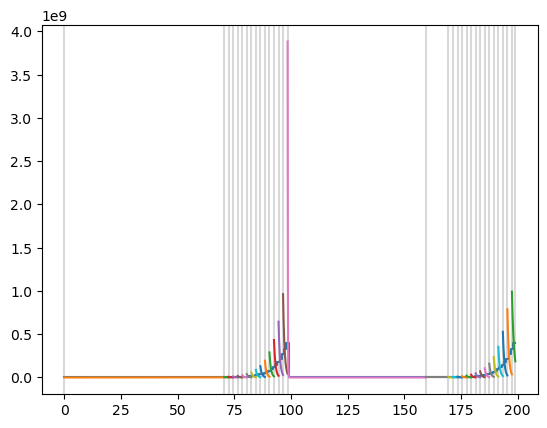

In [17]:
t=np.arange(0,100)/5
x_t=np.floor(np.exp(t))
t=np.arange(0,200)
x = np.concatenate([x_t,x_t])
test_bb_exp(t,x,ExponentialBlocks_Events_Alt_2,ncp_prior = 1000000)